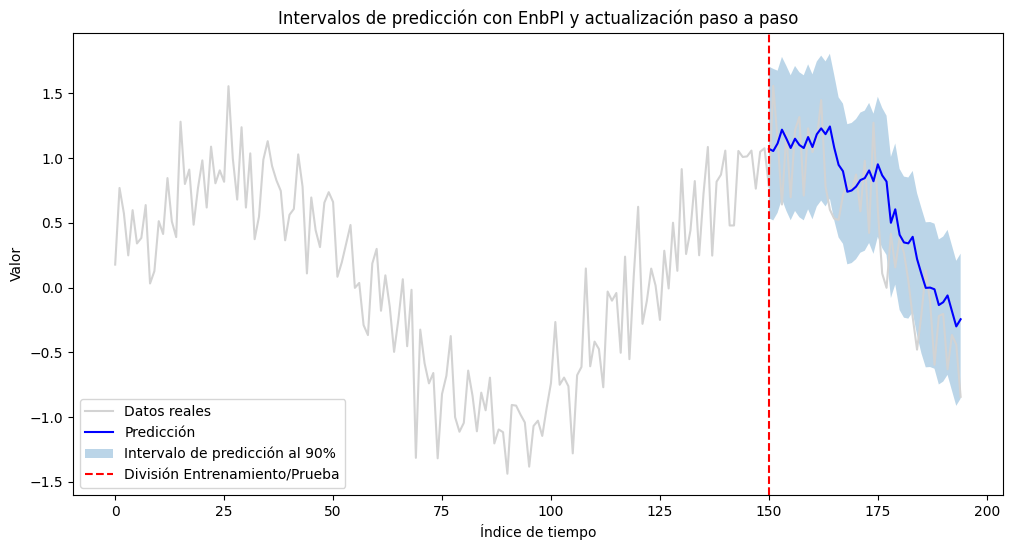

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from mapie.regression import TimeSeriesRegressor
from mapie.subsample import BlockBootstrap

# Semilla para reproducibilidad
np.random.seed(42)

# Crear serie sintética
n_samples = 200
t = np.arange(n_samples)
y = np.sin(t / 20) + np.random.normal(0, 0.3, size=n_samples)

# Generar variables con rezagos (lags)
n_lags = 5
X = np.vstack([t])
for lag in range(1, n_lags + 1):
    lagged = np.roll(y, lag)
    X = np.vstack([X, lagged])
X = X.T
X[:n_lags, :] = np.nan

# Eliminar filas con NaNs
mask = ~np.isnan(X).any(axis=1)
X = X[mask]
y = y[mask]

# Separar entrenamiento y prueba
train_size = 150
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Modelo base
base_model = LinearRegression()

# Remuestreo temporal
cv = BlockBootstrap(n_resamplings=30, n_blocks=70, overlapping=True, random_state=42)

# Modelo MAPIE con EnbPI
mapie_ts = TimeSeriesRegressor(
    estimator=base_model,
    method="enbpi",
    cv=cv,
    agg_function="mean",
    n_jobs=-1,
)

# Entrenamiento inicial
mapie_ts.fit(X_train, y_train)

# Predicción paso a paso
alpha = 0.9
y_pred_pfit = []
y_pis_pfit = []

for i in range(len(X_test)):
    y_pred_i, y_pis_i = mapie_ts.predict(
        X_test[i:i+1],
        confidence_level=alpha,
        ensemble=True,
    )
    y_pred_pfit.append(y_pred_i[0])
    y_pis_pfit.append(y_pis_i[0])
    mapie_ts.partial_fit(X_test[i:i+1], y_test[i:i+1])

y_pred_pfit = np.array(y_pred_pfit)
y_pis_pfit = np.array(y_pis_pfit)

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y)), y, label="Datos reales", color='lightgray')
plt.plot(np.arange(train_size, train_size + len(y_pred_pfit)), y_pred_pfit, label="Predicción", color='blue')
plt.fill_between(
    np.arange(train_size, train_size + len(y_pred_pfit)),
    y_pis_pfit[:, 0, 0],
    y_pis_pfit[:, 1, 0],
    alpha=0.3,
    label="Intervalo de predicción al 90%"
)
plt.axvline(train_size, color='red', linestyle='--', label="División Entrenamiento/Prueba")
plt.legend()
plt.title("Intervalos de predicción con EnbPI y actualización paso a paso")
plt.xlabel("Índice de tiempo")
plt.ylabel("Valor")
plt.show()


Prediction Interval Coverage (target ~0.9): 0.863
Mean Prediction Interval Width: 3.765


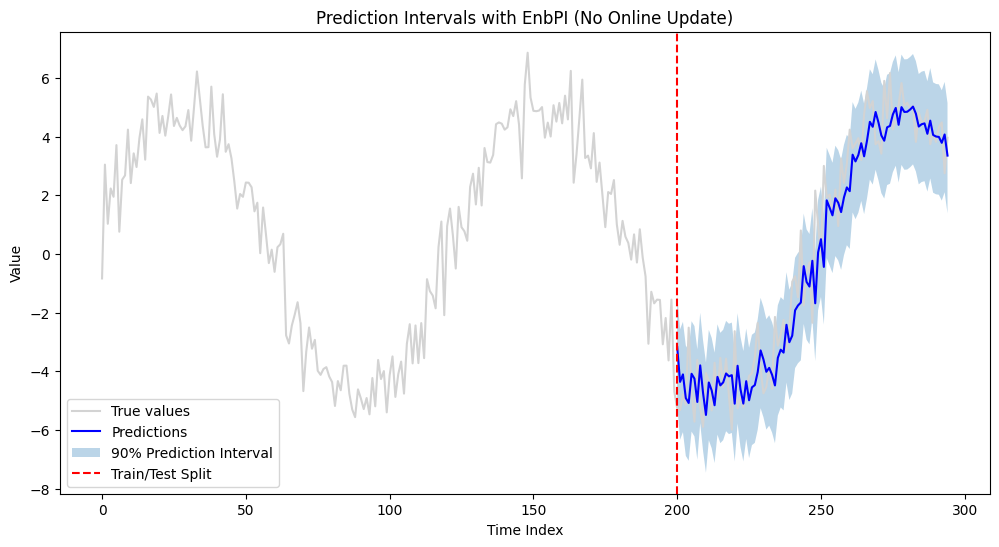

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from mapie.regression import TimeSeriesRegressor
from mapie.subsample import BlockBootstrap
from mapie.metrics.regression import regression_coverage_score, regression_mean_width_score

# Create synthetic time series
np.random.seed(1)
n_samples = 300
t = np.arange(n_samples)
y = 5*np.sin(t / 20) + 3*np.random.normal(0, 0.3, size=n_samples)

# Create lag features
n_lags = 5
X = np.vstack([t])
for lag in range(1, n_lags + 1):
    lagged = np.roll(y, lag)
    X = np.vstack([X, lagged])
X = X.T
X[:n_lags, :] = np.nan  # Remove first rows with missing lags
mask = ~np.isnan(X).any(axis=1)
X = X[mask]
y = y[mask]

# Split into training and testing
train_size = 200
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Base model
base_model = LinearRegression()

# Bootstrap resampling for EnbPI
cv = BlockBootstrap(n_resamplings=30, n_blocks=20, overlapping=True, random_state=42)

# EnbPI without online update
mapie_ts = TimeSeriesRegressor(
    estimator=base_model,
    method="enbpi",
    cv=cv,
    agg_function="mean",
    n_jobs=-1,
)
mapie_ts.fit(X_train, y_train)

# Predict on test set
confidence = 0.9
y_pred, y_pis = mapie_ts.predict(
    X_test,
    confidence_level=confidence,
    ensemble=True
)

# Evaluate coverage and interval width
coverage = regression_coverage_score(y_test, y_pis)[0]
width = regression_mean_width_score(y_pis)[0]

print(f"Prediction Interval Coverage (target ~{confidence}): {coverage:.3f}")
print(f"Mean Prediction Interval Width: {width:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y)), y, label="True values", color='lightgray')
plt.plot(np.arange(train_size, train_size + len(y_pred)), y_pred, label="Predictions", color='blue')
plt.fill_between(
    np.arange(train_size, train_size + len(y_pred)),
    y_pis[:, 0, 0],
    y_pis[:, 1, 0],
    alpha=0.3,
    label=f"{int(confidence*100)}% Prediction Interval"
)
plt.axvline(train_size, color='red', linestyle='--', label="Train/Test Split")
plt.legend()
plt.title("Prediction Intervals with EnbPI (No Online Update)")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.show()

In [3]:
y_pis[:,0,0]

array([-5.14266398, -6.33382007, -6.07854612, -6.88775697, -7.0538711 ,
       -6.05783408, -6.2228403 , -7.01834537, -5.77141469, -6.71775616,
       -7.46173507, -6.3538201 , -6.62721912, -7.13037892, -6.16262536,
       -6.45347644, -6.35030736, -6.04702705, -6.14479669, -6.10377918,
       -7.07763097, -5.78451269, -6.58080866, -7.07518508, -6.31007691,
       -6.96192584, -6.51938837, -6.44334489, -5.9983847 , -5.2607766 ,
       -5.56938782, -5.98968391, -5.85550019, -6.09304891, -6.4552645 ,
       -5.51278015, -5.23585002, -5.33577825, -4.38680125, -4.98079259,
       -4.75839724, -3.89238093, -3.72876355, -3.62745721, -2.38613843,
       -2.92556654, -3.08264865, -2.20352215, -3.65309696, -1.91887821,
       -1.46751973, -2.41190316, -0.14251114, -0.38865936, -0.65255767,
       -0.07110773, -0.2233542 , -0.54220114, -0.03993933,  0.29970215,
        0.17039609,  1.41592912,  1.18632137,  1.40595441,  1.80709845,
        1.35938186,  1.88925866,  2.53598407,  2.36724199,  2.87

Traditional CP - Coverage (expected ~0.9): 0.875
Traditional CP - Mean Interval Width: 3.452


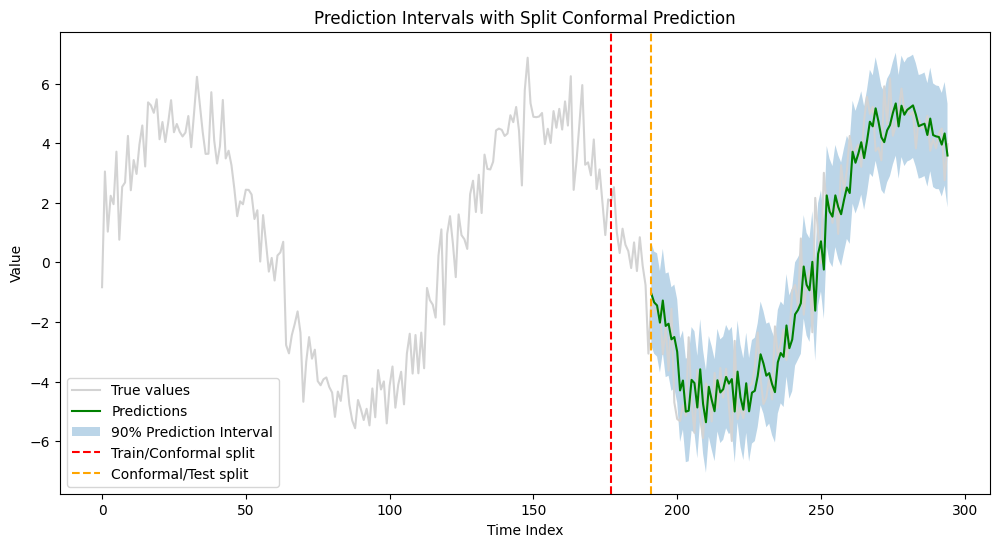

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from mapie.utils import train_conformalize_test_split
from mapie.regression import SplitConformalRegressor, JackknifeAfterBootstrapRegressor
from mapie.metrics.regression import regression_coverage_score, regression_mean_width_score

# Create synthetic time series
np.random.seed(1)
n_samples = 300
t = np.arange(n_samples)
y = 5*np.sin(t / 20) + 3*np.random.normal(0, 0.3, size=n_samples)


# Create lag features
n_lags = 5
X = np.vstack([t])
for lag in range(1, n_lags + 1):
    lagged = np.roll(y, lag)
    X = np.vstack([X, lagged])
X = X.T
X[:n_lags, :] = np.nan
mask = ~np.isnan(X).any(axis=1)
X = X[mask]
y = y[mask]

# Split into train, conformalize and test sets
(X_train, X_conformalize, X_test,
 y_train, y_conformalize, y_test) = train_conformalize_test_split(
    X, y,
    train_size=0.6,
    conformalize_size=0.05,
    test_size=0.35,
    shuffle=False
)

# Initialize model
alpha = 0.1  # 90% prediction interval
base_model = LinearRegression()
# mapie = SplitConformalRegressor(
#     estimator=base_model,
#     confidence_level=1 - alpha,
#     prefit=False
# )

base_model.fit(X_train,y_train)

mapie = JackknifeAfterBootstrapRegressor(
    estimator=base_model,
    confidence_level=1 - alpha,
    method="plus"
)

# Fit and conformalize
# mapie.fit(X_train, y_train)
# mapie.conformalize(X_conformalize, y_conformalize)

mapie.fit_conformalize(X_train,y_train)

# Predict
y_pred, y_pis = mapie.predict_interval(X_test)

# Evaluation metrics
coverage = regression_coverage_score(y_test, y_pis)[0]
width = regression_mean_width_score(y_pis)[0]
print(f"Traditional CP - Coverage (expected ~{1-alpha}): {coverage:.3f}")
print(f"Traditional CP - Mean Interval Width: {width:.3f}")

# Plotting
start_test = len(X_train) + len(X_conformalize)
x_range = np.arange(start_test, start_test + len(y_pred))

y_lower = y_pis[:, 0].ravel()
y_upper = y_pis[:, 1].ravel()


plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y)), y, label="True values", color='lightgray')
plt.plot(x_range, y_pred, label="Predictions", color='green')
plt.fill_between(x_range, y_lower, y_upper, alpha=0.3, label="90% Prediction Interval")
plt.axvline(len(X_train), color='red', linestyle='--', label="Train/Conformal split")
plt.axvline(start_test, color='orange', linestyle='--', label="Conformal/Test split")
plt.legend()
plt.title("Prediction Intervals with Split Conformal Prediction")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.show()


In [5]:
y_upper-y_lower

array([3.45433499, 3.42810692, 3.46737205, 3.40944847, 3.47670759,
       3.47670759, 3.47134534, 3.47670759, 3.47670759, 3.47167821,
       3.47670759, 3.32391353, 3.47670759, 3.47670759, 3.47670759,
       3.40946488, 3.43738851, 3.35185417, 3.47251823, 3.44175497,
       3.38355135, 3.47394965, 3.42129166, 3.44413998, 3.47670759,
       3.46446182, 3.46563744, 3.47029241, 3.47670759, 3.47670759,
       3.41490498, 3.42378223, 3.41430714, 3.35765866, 3.47670759,
       3.47670759, 3.47150394, 3.47670759, 3.47656262, 3.44026263,
       3.47670759, 3.3987211 , 3.47670759, 3.47670759, 3.47670759,
       3.41579684, 3.42051464, 3.44295466, 3.47024759, 3.47670759,
       3.46772071, 3.42913062, 3.44121971, 3.47056638, 3.4407542 ,
       3.47670759, 3.3881254 , 3.41459312, 3.43515734, 3.3942533 ,
       3.334226  , 3.38321828, 3.45502976, 3.39075986, 3.42805985,
       3.47670759, 3.47670759, 3.47670759, 3.45811052, 3.42067278,
       3.45385526, 3.44412669, 3.47670759, 3.46903146, 3.47670